# Property Price Prediction - EDA and Model Training

This notebook explores the real estate data and trains a machine learning model to predict property prices in Poland.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load raw data
df = pd.read_csv('../data/raw/data_final.csv', index_col=0)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (25176, 21)

First few rows:


,Price,Area (m²),Number of rooms,Address,Heating,Market,Advertiser type,Building type,year_const,Windows,...,type,offer_date,Date,CPI,population,gur,average_salary,Latitude,Longitude,voivodeship
0,1999000.0,148.00,4,"ul. Olchowa, Ujeścisko-Łostowice, Gdańsk, pomo...",gazowe,wtórny,prywatny,szeregowiec,2021,plastikowe,...,house,2025-02,2025,100.34,38268383,4.0,8482.47,54.343940,18.590440,pomorskie
1,949000.0,110.17,4,"Wołomin, Wołomin, wołomiński, mazowieckie",gazowe,pierwotny,biuro nieruchomości,bliźniak,2025,plastikowe,...,house,2025-02,2025,100.34,38268383,4.0,8482.47,52.346630,21.238065,mazowieckie
2,729000.0,114.00,5,"ul. Lokalna, Płock, mazowieckie",gazowe,wtórny,biuro nieruchomości,bliźniak,1970,plastikowe,...,house,2025-02,2025,100.34,38268383,4.0,8482.47,51.930034,18.995020,mazowieckie
3,410000.0,82.00,5,"ul. Biała, Glinice, Radom, mazowieckie",gazowe,wtórny,biuro nieruchomości,wolnostojący,1985,plastikowe,...,house,2025-02,2025,100.34,38268383,4.0,8482.47,51.930034,18.995020,mazowieckie
4,439000.0,161.00,4,"Barcino, Kępice, słupski, pomorskie",węglowe,wtórny,biuro nieruchomości,wolnostojący,1997,plastikowe,...,house,2025-02,2025,100.34,38268383,4.0,8482.47,54.276813,16.961084,pomorskie


## 2. Data Exploration

In [3]:
print("=== DATASET INFO ===")
print(df.info())

print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

print("\n=== PRICE STATISTICS ===")
print(df['Price'].describe())

print("\n=== VOIVODESHIPS ===")
print(df['voivodeship'].value_counts())

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 25176 entries, 0 to 25175
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              25176 non-null  float64
 1   Area (m²)          25176 non-null  float64
 2   Number of rooms    25176 non-null  int64  
 3   Address            25176 non-null  str    
 4   Heating            25176 non-null  str    
 5   Market             25176 non-null  str    
 6   Advertiser type    25176 non-null  str    
 7   Building type      25176 non-null  str    
 8   year_const         25176 non-null  int64  
 9   Windows            25176 non-null  str    
 10  Building material  25176 non-null  str    
 11  type               25176 non-null  str    
 12  offer_date         25176 non-null  str    
 13  Date               25176 non-null  int64  
 14  CPI                25176 non-null  float64
 15  population         25176 non-null  int64  
 16  gur         

In [4]:
# Check unique values for categorical features
print("Heating types:", df['Heating'].unique())
print(f"Count: {df['Heating'].nunique()}\n")

print("Building materials:", df['Building material'].unique())
print(f"Count: {df['Building material'].nunique()}\n")

print("Building types:", df['Building type'].unique())
print(f"Count: {df['Building type'].nunique()}\n")

print("Market types:", df['Market'].unique())
print(f"Count: {df['Market'].nunique()}")

Heating types: <StringArray>
[           'gazowe',           'węglowe',      'pompa ciepła',
              'inne',       'elektryczne', 'kominkowe\ngazowe',
          'miejskie',         'kotłownia']
Length: 8, dtype: str
Count: 8

Building materials: <StringArray>
[        'silikat',           'cegła',          'pustak',            'inny',
          'drewno', 'beton komórkowy',           'beton',    'wielka płyta',
          'żelbet',        'keramzyt']
Length: 10, dtype: str
Count: 10

Building types: <StringArray>
[     'szeregowiec',         'bliźniak',     'wolnostojący',
        'kamienica',             'blok',  'apartamentowiec',
 'dom wolnostojący',             'loft',           'plomba']
Length: 9, dtype: str
Count: 9

Market types: <StringArray>
['wtórny', 'pierwotny']
Length: 2, dtype: str
Count: 2


## 3. Data Cleaning and Preprocessing

In [5]:
# Create a copy for processing
df_processed = df.copy()

# Drop rows with missing critical values
df_processed = df_processed.dropna(subset=['Price', 'Area (m²)', 'Number of rooms', 'year_const', 'voivodeship'])

print(f"Shape after removing missing critical values: {df_processed.shape}")
print(f"Rows removed: {len(df) - len(df_processed)}")

Shape after removing missing critical values: (25176, 21)
Rows removed: 0


In [ ]:
# Major Polish cities for mapping
MAJOR_CITIES = {
    'Warszawa', 'Kraków', 'Wrocław', 'Poznań', 'Gdańsk', 'Szczecin', 'Łódź', 'Gdynia',
    'Katowice', 'Białystok', 'Radom', 'Toruń', 'Kielce', 'Lublin', 'Olsztyn', 'Zielona Góra',
    'Rzeszów', 'Opole', 'Elbląg', 'Gorzów Wielkopolski', 'Płock', 'Częstochowa', 'Bydgoszcz',
    'Gliwice', 'Rybnik', 'Zabrze', 'Sosnowiec', 'Bytom', 'Chorzów', 'Dąbrowa Górnicza'
}

def extract_city(address):
    """
    Extract city from address string.
    Address structure: [street], [city/district], [district/county], [voivodeship]
    """
    if pd.isna(address):
        return 'Unknown'
    
    parts = [p.strip() for p in str(address).split(',')]
    
    if len(parts) < 2:
        return 'Unknown'
    
    # Work backwards from voivodeship to find a major city
    for i in range(len(parts) - 2, -1, -1):
        candidate = parts[i]
        if candidate in MAJOR_CITIES:
            return candidate
    
    # If no major city found, use second-to-last element (usually county/city name)
    if len(parts) >= 2:
        return parts[-2]
    
    return 'Unknown'

# Apply extraction
df_processed['city'] = df_processed['Address'].apply(extract_city)

# Verify extraction
print("Sample cities extracted:")
print(df_processed[['Address', 'city']].head(20))

print(f"\nNumber of unique cities: {df_processed['city'].nunique()}")
print(f"\nTop 15 cities/locations:")
print(df_processed['city'].value_counts().head(15))

Sample locations extracted:
                                              Address          city  \
1           Wołomin, Wołomin, wołomiński, mazowieckie    wołomiński   
2                     ul. Lokalna, Płock, mazowieckie         Płock   
3              ul. Biała, Glinice, Radom, mazowieckie         Radom   
4                 Barcino, Kępice, słupski, pomorskie       słupski   
6    Kretowiny, Morąg, ostródzki, warmińsko-mazurskie     ostródzki   
7       Malin, Wisznia Mała, trzebnicki, dolnośląskie    trzebnicki   
8   ul. Szkolna, Rokietnica, Rokietnica, poznański...     poznański   
10            Wodzisław Śląski, wodzisławski, śląskie  wodzisławski   
11             Psarskie, Śrem, śremski, wielkopolskie       śremski   
12  Grodzisk Mazowiecki, Grodzisk Mazowiecki, grod...     grodziski   
13  Skałowska, Gwiazdowo, Kostrzyn, poznański, wie...     poznański   
14  Rydzyńska, Dąbcze, Rydzyna, leszczyński, wielk...   leszczyński   
15        ul. Słoneczna, Kozy, Kozy, bielski, ślą

In [29]:
# Remove outliers in price and area
price_q1, price_q3 = df_processed['Price'].quantile([0.01, 0.99])
area_q1, area_q3 = df_processed['Area (m²)'].quantile([0.01, 0.99])

print(f"Price range (1%-99%): {price_q1} - {price_q3}")
print(f"Area range (1%-99%): {area_q1} - {area_q3}")

df_processed = df_processed[
    (df_processed['Price'] >= price_q1) & 
    (df_processed['Price'] <= price_q3) &
    (df_processed['Area (m²)'] >= area_q1) & 
    (df_processed['Area (m²)'] <= area_q3)
]

print(f"\nShape after removing outliers: {df_processed.shape}")

Price range (1%-99%): 73934.8740338476 - 1058141.6729959138
Area range (1%-99%): 22.569457394025573 - 175.39008547589785

Shape after removing outliers: (22297, 23)


In [30]:
# Handle missing values in categorical features
df_processed['Heating'].fillna('inne', inplace=True)
df_processed['Building material'].fillna('inny', inplace=True)
df_processed['Market'].fillna('wtórny', inplace=True)

print("Missing values after handling:")
print(df_processed[['Heating', 'Building material', 'Market', 'Building type']].isnull().sum())

Missing values after handling:
Heating              0
Building material    0
Market               0
Building type        0
dtype: int64


## 4. Feature Selection and Engineering

In [9]:
# Select features for model
features = [
    'Area (m²)',
    'Number of rooms',
    'year_const',
    'Heating',
    'Building material',
    'Building type',
    'Market',
    'voivodeship'
]

# Create feature matrix and target
X = df_processed[features].copy()
y = df_processed['Price'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (24181, 8)
Target shape: (24181,)

Features: ['Area (m²)', 'Number of rooms', 'year_const', 'Heating', 'Building material', 'Building type', 'Market', 'voivodeship']


In [10]:
# Encode categorical features
categorical_features = ['Heating', 'Building material', 'Building type', 'Market', 'voivodeship']
label_encoders = {}

X_encoded = X.copy()

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nEncoded features shape: {X_encoded.shape}")
print(X_encoded.head())

Heating: {'elektryczne': np.int64(0), 'gazowe': np.int64(1), 'inne': np.int64(2), 'kominkowe\ngazowe': np.int64(3), 'kotłownia': np.int64(4), 'miejskie': np.int64(5), 'pompa ciepła': np.int64(6), 'węglowe': np.int64(7)}
Building material: {'beton': np.int64(0), 'beton komórkowy': np.int64(1), 'cegła': np.int64(2), 'drewno': np.int64(3), 'inny': np.int64(4), 'keramzyt': np.int64(5), 'pustak': np.int64(6), 'silikat': np.int64(7), 'wielka płyta': np.int64(8), 'żelbet': np.int64(9)}
Building type: {'apartamentowiec': np.int64(0), 'bliźniak': np.int64(1), 'blok': np.int64(2), 'dom wolnostojący': np.int64(3), 'kamienica': np.int64(4), 'loft': np.int64(5), 'plomba': np.int64(6), 'szeregowiec': np.int64(7), 'wolnostojący': np.int64(8)}
Market: {'pierwotny': np.int64(0), 'wtórny': np.int64(1)}
voivodeship: {'dolnośląskie': np.int64(0), 'kujawsko-pomorskie': np.int64(1), 'lubelskie': np.int64(2), 'lubuskie': np.int64(3), 'mazowieckie': np.int64(4), 'małopolskie': np.int64(5), 'opolskie': np.int6

## 5. Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set price range: {y_train.min()} - {y_train.max()}")
print(f"Test set price range: {y_test.min()} - {y_test.max()}")

Training set size: 19344
Test set size: 4837

Training set price range: 56415.16266195948 - 1377180.3564724834
Test set price range: 56472.4091750049 - 1369701.0


## 6. Train Random Forest Model

In [31]:
# Train Random Forest Regressor
print("Training Random Forest model...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)
print("Model training completed!")

Training Random Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s


Model training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


## 7. Model Evaluation

In [13]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("=== MODEL PERFORMANCE ===")
print(f"\nTraining Set:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:,.2f} PLN")
print(f"  MAE: {train_mae:,.2f} PLN")

print(f"\nTest Set:")
print(f"  R² Score: {test_r2:.4f}")
print(f"  RMSE: {test_rmse:,.2f} PLN")
print(f"  MAE: {test_mae:,.2f} PLN")

=== MODEL PERFORMANCE ===

Training Set:
  R² Score: 0.8748
  RMSE: 85,453.00 PLN
  MAE: 63,925.48 PLN

Test Set:
  R² Score: 0.6364
  RMSE: 148,161.29 PLN
  MAE: 112,492.14 PLN


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



=== FEATURE IMPORTANCE ===
             feature  importance
6             Market    0.558734
0          Area (m²)    0.150102
2         year_const    0.140229
1    Number of rooms    0.054439
7        voivodeship    0.040403
5      Building type    0.024256
4  Building material    0.018064
3            Heating    0.013774


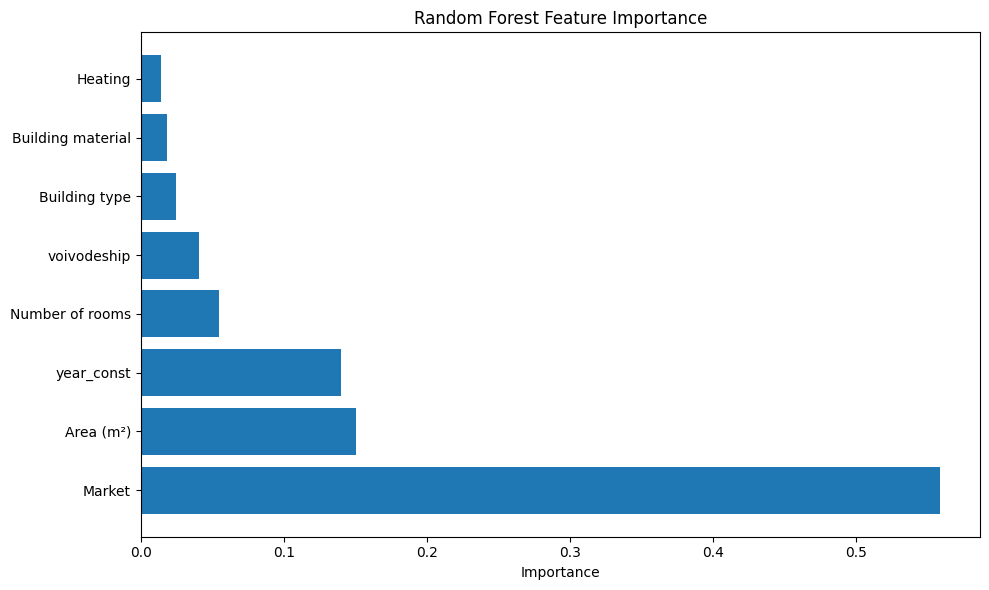

In [26]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

## 8. Save Model and Encoders

In [14]:
# Save model
joblib.dump(model, '../models/price_model.joblib')
print("Model saved to ../models/price_model.joblib")

# Save label encoders
joblib.dump(label_encoders, '../models/label_encoders.joblib')
print("Label encoders saved to ../models/label_encoders.joblib")

# Save feature list
joblib.dump(features, '../models/features.joblib')
print("Features list saved to ../models/features.joblib")

# Save processed data for reference
df_processed.to_csv('../data/processed/data_processed.csv')
print("Processed data saved to ../data/processed/data_processed.csv")

Model saved to ../models/price_model.joblib
Label encoders saved to ../models/label_encoders.joblib
Features list saved to ../models/features.joblib
Processed data saved to ../data/processed/data_processed.csv


In [15]:
print("\n=== TRAINING SUMMARY ===")
print(f"Dataset size: {len(df_processed)} properties")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nModel: Random Forest Regressor")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:,.2f} PLN")
print(f"\nModel and encoders saved successfully!")


=== TRAINING SUMMARY ===
Dataset size: 24181 properties
Training samples: 19344
Test samples: 4837

Model: Random Forest Regressor
Test R² Score: 0.6364
Test RMSE: 148,161.29 PLN

Model and encoders saved successfully!
